In [1]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT/"src"))

# Startup checks
from config import CLEAN_FILE
from startup_checks import ensure_project_dirs, check_required_data, check_required_artifacts

ensure_project_dirs()
check_required_data(CLEAN_FILE)
# tokenization_config.json is required
check_required_artifacts(
    require_comparison_artifacts=False,
    require_model_key_artifacts=False
)

print("Clean data:", CLEAN_FILE)

All required artifacts are found. Notebook is ready
Clean data: /home/tl/stock-news-sentiment-bert-finbert/data/processed/financial_phrasebank_clean.csv


In [2]:
from config import TEXT_COL, LABEL_COL, FINBERT_KEY, HF_MODELS, RANDOM_STATE
from preprocess import load_and_clean_data
from utils import build_label_mappings, check_unseen_labels, encode_labels, build_tokenize_batch_fn, compute_classification_metrics
from artifacts_utils import (
save_label_map, save_training_log_history, save_split_metrics, save_split_prediction, save_best_model_info, save_split_evaluation,
get_tuning_model_dir, get_best_model_dir,
load_tokenization_config, load_label_map_for_model)
from hf_utils import build_hf_map_fn, create_hf_datasets
from eval_utils import evaluate_and_plot
from models import build_sequence_classifier
from inference import build_prediction_df, predict_labels

from transformers import set_seed, AutoTokenizer, TrainingArguments, Trainer
from datasets import Dataset

from sklearn.model_selection import train_test_split

import pandas as pd
import torch

In [3]:
# Load tokenization configuration
tokenization_cfg = load_tokenization_config()

max_length = tokenization_cfg["max_length"]
padding = tokenization_cfg["padding"]
truncation = tokenization_cfg["truncation"]

finbert_model_id = HF_MODELS[FINBERT_KEY]["model_id"]

print("FinBERT model:", finbert_model_id)
print("Tokenization config:", tokenization_cfg)

FinBERT model: ProsusAI/finbert
Tokenization config: {'baseline_max_length': 96, 'max_length': 96, 'padding': 'max_length', 'truncation': True, 'selection_method': 'truncation_efficiency_tradeoff', 'truncation_threshold_pct': 1.0}


In [4]:
# Load dataset
df = load_and_clean_data(CLEAN_FILE, basic_clean=False, clean_label=False)

print(df.head())
print()
print(df[LABEL_COL].value_counts())

                                                text     label
0  The GeoSolutions technology will leverage Bene...  positive
1  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative
2  For the last quarter of 2010 , Componenta 's n...  positive
3  According to the Finnish-Russian Chamber of Co...   neutral
4  The Swedish buyout firm has sold its remaining...   neutral

label
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64


In [5]:
# Split dataset into train, validation and test set
set_seed(RANDOM_STATE)

df_train, df_temp = train_test_split(
    df,
    stratify=df[LABEL_COL],
    test_size=0.2,    # train 80% | temp 20%
    random_state=RANDOM_STATE
)

df_val, df_test = train_test_split(
    df_temp,
    stratify=df_temp[LABEL_COL],
    test_size=0.5,    # validation 10% | test 10%
    random_state=RANDOM_STATE
)

for name, part in [("train", df_train), ("validation", df_val), ("test", df_test)]:
    print(f"{name} size: {len(part)}")
    print(f"{name} label %:")
    print(f"{(part[LABEL_COL].value_counts(normalize=True)*100).round(2)}\n")

train size: 4673
train label %:
label
neutral     53.58
positive    31.69
negative    14.72
Name: proportion, dtype: float64

validation size: 584
validation label %:
label
neutral     53.60
positive    31.68
negative    14.73
Name: proportion, dtype: float64

test size: 585
test label %:
label
neutral     53.50
positive    31.79
negative    14.70
Name: proportion, dtype: float64



In [6]:
# Label mapping + sanity checks + label encoding + save label_map.json
label_order, label_to_id, id_to_label = build_label_mappings(df_train[LABEL_COL]) # from train dataset only

print(f"label_order: {label_order}, {type(label_order)}")
print(f"label_to_id: {label_to_id}, {type(label_to_id)}")
print(f"id_to_label: {id_to_label}, {type(id_to_label)}\n")

# Sanity checks
check_unseen_labels(
    labels=df_val[LABEL_COL],
    label_to_id=label_to_id,
    split_name="validation"
)

check_unseen_labels(
    labels=df_test[LABEL_COL],
    label_to_id=label_to_id,
    split_name="test"
)

# label encoding
df_train = df_train.copy()
df_val = df_val.copy()
df_test = df_test.copy()

df_train["label_encoded"] = encode_labels(df_train[LABEL_COL], label_to_id)
df_val["label_encoded"] = encode_labels(df_val[LABEL_COL], label_to_id)
df_test["label_encoded"] = encode_labels(df_test[LABEL_COL], label_to_id)

display(df_train.head())

# Save label mappings as label_map.json
label_map_path = save_label_map(
    model_key=FINBERT_KEY,
    label_order=label_order,
    label_to_id=label_to_id,
    id_to_label=id_to_label
)

print("Saved label map to:", label_map_path)

label_order: ['negative', 'neutral', 'positive'], <class 'list'>
label_to_id: {'negative': 0, 'neutral': 1, 'positive': 2}, <class 'dict'>
id_to_label: {0: 'negative', 1: 'neutral', 2: 'positive'}, <class 'dict'>



,text,label,label_encoded
1247,"National Conciliator Juhani Salonius , who met...",negative,0
966,The goal is to secure the company 's profitabi...,neutral,1
4456,M-real Corporation Stock Exchange Announcement...,neutral,1
1385,$FB watching for bounce tomorrow,positive,2
5190,That would be an increase from estimated sales...,positive,2


Saved to /home/tl/stock-news-sentiment-bert-finbert/artifacts/preprocessing/finbert/label_map.json
Saved label map to: /home/tl/stock-news-sentiment-bert-finbert/artifacts/preprocessing/finbert/label_map.json


In [7]:
# Load tokenizer + build tokenize function
finbert_tokenizer = AutoTokenizer.from_pretrained(finbert_model_id, use_fast=True)

tokenize_batch = build_tokenize_batch_fn(
    tokenizer=finbert_tokenizer,
    max_length=max_length,
    padding=padding,
    truncation=truncation,
    return_tensors=None
)

In [8]:
# Convert to Hugging Face dataset + tokenize
hf_map_fn = build_hf_map_fn(
    tokenize_batch=tokenize_batch,
    text_col=TEXT_COL
)

ds_train, ds_val, ds_test = create_hf_datasets(
    df_train=df_train,
    df_val=df_val,
    df_test=df_test,
    hf_map_fn=hf_map_fn
)

Map:   0%|          | 0/4673 [00:00<?, ? examples/s]

Map:   0%|          | 0/584 [00:00<?, ? examples/s]

Map:   0%|          | 0/585 [00:00<?, ? examples/s]

In [9]:
# Pre-trained model init
model = build_sequence_classifier(
    finbert_model_id,
    num_labels=len(label_order),
    label_to_id=label_to_id,
    id_to_label=id_to_label
)

In [10]:
training_arg = TrainingArguments(
    output_dir=str(get_tuning_model_dir(FINBERT_KEY)),
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.1,
    logging_steps=50,
    report_to="none",
    save_total_limit=3,
    fp16=torch.cuda.is_available(),    # GPU support only for acceleration
    seed=RANDOM_STATE
)

trainer = Trainer(
    model=model,
    args=training_arg,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    processing_class=finbert_tokenizer,
    compute_metrics=compute_classification_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted Precision,Weighted Recall,Weighted F1
1,0.443900,0.428350,0.806507,0.761411,0.811377,0.775123,0.837464,0.806507,0.814213
2,0.297800,0.429024,0.785959,0.722321,0.730260,0.725514,0.794015,0.785959,0.789572
3,0.182500,0.521567,0.782534,0.710836,0.672374,0.685474,0.771289,0.782534,0.772309
4,0.193100,0.562103,0.777397,0.690717,0.663694,0.672670,0.762691,0.777397,0.766782
5,0.144800,0.565923,0.782534,0.698508,0.684764,0.689507,0.769777,0.782534,0.774962


TrainOutput(global_step=1465, training_loss=0.29219899340294325, metrics={'train_runtime': 156.8579, 'train_samples_per_second': 148.957, 'train_steps_per_second': 9.34, 'total_flos': 1152683438477760.0, 'train_loss': 0.29219899340294325, 'epoch': 5.0})

In [11]:
# Inspect best checkpoint
best_checkpoint = trainer.state.best_model_checkpoint
best_metric = trainer.state.best_metric
global_step = trainer.state.global_step

print("Best checkpoint:", best_checkpoint)
print("Best metric:", best_metric)
print("Global steps:", global_step)

Best checkpoint: /home/tl/stock-news-sentiment-bert-finbert/artifacts/models/tuning/finbert/checkpoint-293
Best metric: 0.7751226453612198
Global steps: 1465


In [12]:
# Save best model
best_model_path = get_best_model_dir(FINBERT_KEY)

trainer.save_model(best_model_path)
finbert_tokenizer.save_pretrained(best_model_path)

print("Saved BEST model+tokenizer to:", best_model_path)
print("From checkpoint:", best_checkpoint)

Saved BEST model+tokenizer to: /home/tl/stock-news-sentiment-bert-finbert/artifacts/models/best/finbert
From checkpoint: /home/tl/stock-news-sentiment-bert-finbert/artifacts/models/tuning/finbert/checkpoint-293


In [13]:
# Save best model information
best_model_info = {
    "best_model_checkpoint": best_checkpoint,
    "best_metric": float(best_metric),
    "metric_for_best_model": trainer.args.metric_for_best_model,
    "global_step": int(global_step),
    "model_key": FINBERT_KEY,
}

best_model_info_path = save_best_model_info(FINBERT_KEY, best_model_info)
print("Saved best model info to:", best_model_info_path)

Saved to /home/tl/stock-news-sentiment-bert-finbert/artifacts/models/best/finbert/best_model_info.json
Saved best model info to: /home/tl/stock-news-sentiment-bert-finbert/artifacts/models/best/finbert/best_model_info.json


In [14]:
# Save training log history
df_log = pd.DataFrame(trainer.state.log_history)

train_log_path = save_training_log_history(
    model_key=FINBERT_KEY,
    df_train_log=df_log,
)

print("Saved training log history to:", train_log_path)
display(df_log.tail(10))

Training log history saved to: /home/tl/stock-news-sentiment-bert-finbert/artifacts/results/finbert/training_log_history.csv
Saved training log history to: /home/tl/stock-news-sentiment-bert-finbert/artifacts/results/finbert/training_log_history.csv


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_macro_precision,eval_macro_recall,eval_macro_f1,...,eval_weighted_recall,eval_weighted_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
25,0.1931,3.742067,4.313993e-06,3.924915,1150,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,NaN,NaN,NaN,4.000000,1172,0.562103,0.777397,0.690717,0.663694,0.672670,...,0.777397,0.766782,0.9312,627.128,20.403,NaN,NaN,NaN,NaN,NaN
27,0.1516,1.342241,3.631399e-06,4.095563,1200,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,0.1423,3.477726,2.948805e-06,4.266212,1250,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,0.1585,5.554924,2.266212e-06,4.436860,1300,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,0.1457,7.821169,1.583618e-06,4.607509,1350,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,0.1636,3.469060,9.010239e-07,4.778157,1400,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,0.1448,9.401454,2.184300e-07,4.948805,1450,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,NaN,NaN,NaN,5.000000,1465,0.565923,0.782534,0.698508,0.684764,0.689507,...,0.782534,0.774962,0.8907,655.670,21.332,NaN,NaN,NaN,NaN,NaN
34,NaN,NaN,NaN,5.000000,1465,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,156.8579,148.957,9.34,1.152683e+15,0.292199


In [15]:
# Evaluate validation set
val_metrics = trainer.evaluate(eval_dataset=ds_val)

# Save validation metrics
val_metrics_path = save_split_metrics(
    model_key=FINBERT_KEY,
    metrics=val_metrics,
    split_type="val"
)

print("Saved validation metrics to:", val_metrics_path)

Saved to /home/tl/stock-news-sentiment-bert-finbert/artifacts/results/finbert/val_metrics.json
Saved validation metrics to: /home/tl/stock-news-sentiment-bert-finbert/artifacts/results/finbert/val_metrics.json


In [16]:
# Evaluate test set
test_metrics = trainer.evaluate(eval_dataset=ds_test)

# Save test metrics
test_metrics_path = save_split_metrics(
    model_key=FINBERT_KEY,
    metrics=test_metrics,
    split_type="test"
)

print("Saved test metrics to:", test_metrics_path)

Saved to /home/tl/stock-news-sentiment-bert-finbert/artifacts/results/finbert/test_metrics.json
Saved test metrics to: /home/tl/stock-news-sentiment-bert-finbert/artifacts/results/finbert/test_metrics.json


In [17]:
# Load label map for prediction
loaded_label_order, loaded_label_to_id, loaded_id_to_label = load_label_map_for_model(FINBERT_KEY)
target_names = [str(label) for label in loaded_label_order]

print(target_names)

['negative', 'neutral', 'positive']


In [18]:
# Validation set prediction
logits_val, y_true_val, y_pred_val = predict_labels(trainer, ds_val)

df_pred_val = build_prediction_df(
    y_true=y_true_val,
    y_pred=y_pred_val,
    id_to_label=loaded_id_to_label
)

display(df_pred_val.head(10))

df_pred_val_path = save_split_prediction(
    model_key=FINBERT_KEY,
    split_type="val",
    df_pred=df_pred_val    
)

print("Saved validation prediction CSV to:", df_pred_val_path)

,y_true,y_true_label,y_pred,y_pred_label,is_correct
0,1,neutral,1,neutral,True
1,1,neutral,1,neutral,True
2,2,positive,2,positive,True
3,2,positive,2,positive,True
4,2,positive,2,positive,True
5,1,neutral,0,negative,False
6,2,positive,2,positive,True
7,1,neutral,2,positive,False
8,0,negative,0,negative,True
9,1,neutral,1,neutral,True


Val prediction saved to: /home/tl/stock-news-sentiment-bert-finbert/artifacts/results/finbert/val_prediction.csv
Saved validation prediction CSV to: /home/tl/stock-news-sentiment-bert-finbert/artifacts/results/finbert/val_prediction.csv


              precision    recall  f1-score   support

    negative       0.53      0.79      0.63        86
     neutral       0.93      0.77      0.84       313
    positive       0.83      0.87      0.85       185

    accuracy                           0.81       584
   macro avg       0.76      0.81      0.78       584
weighted avg       0.84      0.81      0.81       584



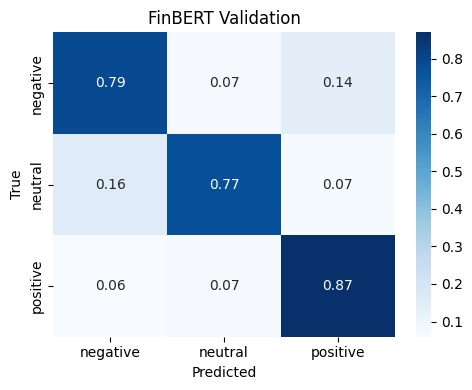

Saved to /home/tl/stock-news-sentiment-bert-finbert/artifacts/results/finbert/val_evaluation.json
Saved validation evaluation to: /home/tl/stock-news-sentiment-bert-finbert/artifacts/results/finbert/val_evaluation.json


In [19]:
# Validation set evaluation
val_eval = evaluate_and_plot(
    y_true=y_true_val,
    y_pred=y_pred_val,
    label_order=loaded_label_order,
    cm_normalize="true",
    title="FinBERT Validation",
)

val_eval_path = save_split_evaluation(
    model_key=FINBERT_KEY,
    split_type="val",
    evaluation=val_eval
)

print("Saved validation evaluation to:", val_eval_path)

In [20]:
# Test set prediction
logits_test, y_true_test, y_pred_test = predict_labels(trainer, ds_test)

df_pred_test = build_prediction_df(
    y_true=y_true_test,
    y_pred=y_pred_test,
    id_to_label=loaded_id_to_label
)

display(df_pred_test.head(10))

df_pred_test_path = save_split_prediction(
    model_key=FINBERT_KEY,
    split_type="test",
    df_pred=df_pred_test    
)

print("Saved test prediction CSV to:", df_pred_test_path)

,y_true,y_true_label,y_pred,y_pred_label,is_correct
0,1,neutral,0,negative,False
1,1,neutral,1,neutral,True
2,2,positive,2,positive,True
3,1,neutral,1,neutral,True
4,2,positive,2,positive,True
5,1,neutral,0,negative,False
6,1,neutral,1,neutral,True
7,1,neutral,1,neutral,True
8,1,neutral,1,neutral,True
9,1,neutral,1,neutral,True


Test prediction saved to: /home/tl/stock-news-sentiment-bert-finbert/artifacts/results/finbert/test_prediction.csv
Saved test prediction CSV to: /home/tl/stock-news-sentiment-bert-finbert/artifacts/results/finbert/test_prediction.csv


              precision    recall  f1-score   support

    negative       0.50      0.76      0.60        86
     neutral       0.93      0.78      0.85       313
    positive       0.84      0.87      0.85       186

    accuracy                           0.80       585
   macro avg       0.76      0.80      0.77       585
weighted avg       0.84      0.80      0.81       585



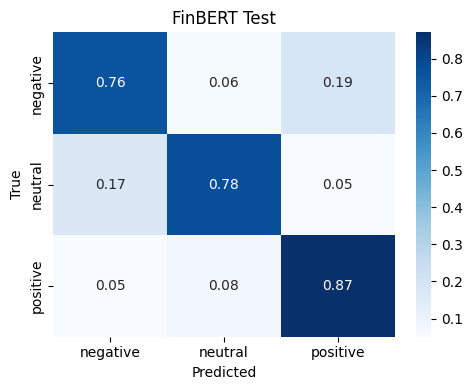

Saved to /home/tl/stock-news-sentiment-bert-finbert/artifacts/results/finbert/test_evaluation.json
Saved test evaluation to: /home/tl/stock-news-sentiment-bert-finbert/artifacts/results/finbert/test_evaluation.json


In [21]:
# Test set evaluation
test_eval = evaluate_and_plot(
    y_true=y_true_test,
    y_pred=y_pred_test,
    label_order=loaded_label_order,
    cm_normalize="true",
    title="FinBERT Test",
)

test_eval_path = save_split_evaluation(
    model_key=FINBERT_KEY,
    split_type="test",
    evaluation=test_eval
)

print("Saved test evaluation to:", test_eval_path)

## Summary - Transformer (FinBERT) Training and Evaluation

### Objective
To train, evaluate, and export a finance-domain Transformer model (FinBERT) using the same pipeline as the BERT baseline, enabling controlled comparison across models.

## Work Performed
- Executed end-to-end training of a FinBERT-based text classification pipeline
- Reused identical data splitting, label encoding, and evaluation procedures to ensure comparability
- Evaluated model performance on validation and test datasets
- Generated prediction outputs and structured evaluation results
- Exported all model artifacts for downstream analysis and comparison

## Key Decisions
- Maintained identical preprocessing, training, and evaluation settings as the BERT baseline
- Treated label mapping and evaluation outputs as first-class artifacts to ensure consistency
- Used macro-averaged metrics to support class-balanced assessment
 
## Results
- A trained and validated FinBERT-based classification model
- Comparable evaluation outputs aligned with the BERT baseline
- Full traceability between predictions, metrics, and saved artifacts

## Artifacts Produced
- Label mapping:
  - **artifacts/preprocessing/finbert/label_map.json**
- Best trained model and tokenizer artifacts:
  - **artifacts/models/best/finbert/**
      - **config.json**
      - **model.safetensors**
      - **special_tokens_map.json**
      - **tokenizer.json**
      - **tokenizer_config.json**
      - **training_args.bin**
      - **vocab.txt**
- Best model metadata:
  - **artifacts/models/best/finbert/best_model_info.json**
- Training history:
  - **artifacts/results/finbert/training_log_history.csv**
- Evaluation metrics (Trainer outputs):
  - **artifacts/results/finbert/**
      - **val_metrics.json**
      - **test_metrics.json**
- Structured evaluation results:
  - **artifacts/results/finbert/**
      - **val_evaluation.json**
      - **test_evaluation.json**
- Prediction outputs:
  - **artifacts/results/finbert/**
      - **val_prediction.csv** 
      - **test_prediction.csv**

## Takeaway
This notebook completes the training and evaluation of a domain-adapted Transformer model (FinBERT).
All outputs are exported as structured artifacts, enabling direct comparison with the BERT baseline and informed model selection in subsequent analysis.